In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from pathlib import Path

BASE = Path("/content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object")
IMG_DIR = BASE / "data_object_image_2" / "training" / "image_2"
LBL_DIR = BASE / "data_object_label_2" / "training" / "label_2"

assert IMG_DIR.exists(), IMG_DIR
assert LBL_DIR.exists(), LBL_DIR

imgs_all = sorted(IMG_DIR.glob("*.png"))
print("Total train images:", len(imgs_all))

START = 0
N = 200
selected = imgs_all[START:START+N]
print(f"Selected batch: START={START}, N={N}, actual={len(selected)}")
print("First/last:", selected[0].name if selected else None, "->", selected[-1].name if selected else None)


Mounted at /content/drive
Total train images: 7497
Selected batch: START=0, N=200, actual=200
First/last: 000000.png -> 000199.png


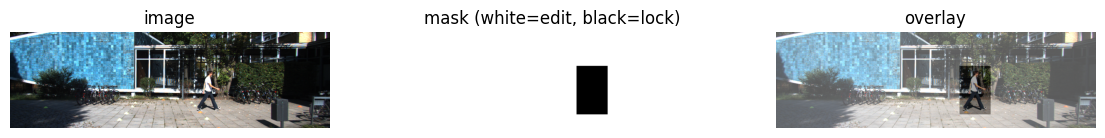

Image: 000000.png Boxes: 1


In [17]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def parse_kitti_boxes(lbl_path: Path):
    boxes = []
    if not lbl_path.exists():
        return boxes
    for line in lbl_path.read_text().splitlines():
        if not line.strip():
            continue
        parts = line.split()
        if parts[0] == "DontCare":
            continue
        left, top, right, bottom = map(float, parts[4:8])
        if right > left and bottom > top:
            boxes.append((left, top, right, bottom))
    return boxes

PAD = 10

img_path = selected[0]
lbl_path = LBL_DIR / (img_path.stem + ".txt")

img = Image.open(img_path).convert("RGB")
W, H = img.size

mask = Image.new("L", (W, H), 255)
draw = ImageDraw.Draw(mask)

for (l,t,r,b) in parse_kitti_boxes(lbl_path):
    l = max(0, int(l - PAD)); t = max(0, int(t - PAD))
    r = min(W-1, int(r + PAD)); b = min(H-1, int(b + PAD))
    draw.rectangle([l,t,r,b], fill=0)

overlay = Image.blend(img, Image.merge("RGB",(mask,mask,mask)), alpha=0.35)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.title("image"); plt.imshow(img); plt.axis("off")
plt.subplot(1,3,2); plt.title("mask (white=edit, black=lock)"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("overlay"); plt.imshow(overlay); plt.axis("off")
plt.show()

print("Image:", img_path.name, "Boxes:", len(parse_kitti_boxes(lbl_path)))


In [18]:
!pip -q install -U diffusers transformers accelerate safetensors opencv-python

import torch, cv2, numpy as np
from PIL import Image
from diffusers import ControlNetModel, StableDiffusionXLControlNetInpaintPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

BASE_MODEL = "SG161222/RealVisXL_V4.0"
CONTROLNET = "diffusers/controlnet-canny-sdxl-1.0"

controlnet = ControlNetModel.from_pretrained(CONTROLNET, torch_dtype=dtype)

pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    torch_dtype=dtype,
    use_safetensors=True,
)


pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception as e:
    print("xformers not enabled:", e)

print("Loaded OK")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

xformers not enabled: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
Loaded OK


In [19]:
def make_canny(img_pil: Image.Image, low=120, high=220):
    img = np.array(img_pil)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low, high)
    edges_3c = np.stack([edges]*3, axis=-1)
    return Image.fromarray(edges_3c)

def save_pair(compare_dir: Path, img_path: Path, original_img: Image.Image, synthetic_img: Image.Image, tag=""):
    compare_dir.mkdir(parents=True, exist_ok=True)
    stem = img_path.stem
    ext = img_path.suffix
    orig_out = compare_dir / f"{stem}{ext}"
    suffix = f"_{tag}_S" if tag else "_S"
    synth_out = compare_dir / f"{stem}{suffix}{ext}"
    if not orig_out.exists():
        original_img.save(orig_out)
    synthetic_img.save(synth_out)


In [ ]:
from PIL import Image, ImageDraw
import torch

PROMPTS = {
    "snow": "same scene, same viewpoint, photorealistic dashcam photo, severe blizzard, dense falling snow, very large snowflakes close to camera, thick snowy haze, extremely low visibility, wet reflective asphalt, slush, winter storm",
    "rain": "same scene, same viewpoint, photorealistic dashcam photo, extreme heavy rainstorm, raindrops on windshield, water streaks, strong spray mist, wet glossy road reflections, stormy dark clouds, low visibility",
    "fog":  "same scene, same viewpoint, photorealistic dashcam photo, extremely thick fog, dense gray mist, heavy haze, very low visibility, diffused light, muted colors, foggy atmosphere"
}

NEG = (
    "scene change, different location, different road, different perspective, "
    "new objects, extra cars, duplicated vehicles, missing vehicles, "
    "warped road, deformed objects, distorted geometry, "
    "cartoon, anime, illustration, CGI, text, watermark, logo"
)

strength = 0.85
cfg = 7.5
steps = 30
PAD = 10
controlnet_scale = 0.6
feather=10

for weather in ["snow", "rain", "fog"]:
    OUT_DIR = BASE / "synth_controlnet" / weather / "images" / "train"
    COMPARE_DIR = BASE / "synth_controlnet" / weather / "compare_train"
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    COMPARE_DIR.mkdir(parents=True, exist_ok=True)

    for i, img_path in enumerate(selected, 1):
        lbl_path = LBL_DIR / (img_path.stem + ".txt")
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        mask = Image.new("L", (W, H), 255)
        draw = ImageDraw.Draw(mask)
        for (l, t, r, b) in parse_kitti_boxes(lbl_path):
            l = max(0, int(l - PAD)); t = max(0, int(t - PAD))
            r = min(W - 1, int(r + PAD)); b = min(H - 1, int(b + PAD))
            draw.rectangle([l, t, r, b], fill=0)

        canny = make_canny(img, low=120, high=220)

        gen = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu").manual_seed(2000 + i)

        out = pipe(
            prompt=PROMPTS[weather],
            negative_prompt=NEG,
            image=img,
            mask_image=mask,
            control_image=canny,
            strength=strength,
            guidance_scale=cfg,
            num_inference_steps=steps,
            controlnet_conditioning_scale=controlnet_scale,
            generator=gen
        ).images[0]

        out.save(OUT_DIR / img_path.name)
        save_pair(COMPARE_DIR, img_path, img, out, tag=weather)

        print(f"[{weather}] saved {i}/{len(selected)}")

    print(f"DONE {weather}.")
    print("synthetic:", OUT_DIR)
    print("compare:", COMPARE_DIR)



  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 1/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 2/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 3/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 4/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 5/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 6/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 7/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 8/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 9/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 10/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 11/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 12/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 13/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 14/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 15/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 16/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 17/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 18/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 19/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 20/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 21/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 22/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 23/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 24/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 25/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 26/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 27/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 28/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 29/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 30/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 31/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 32/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 33/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 34/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 35/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 36/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 37/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 38/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 39/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 40/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 41/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 42/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 43/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 44/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 45/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 46/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 47/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 48/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 49/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 50/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 51/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 52/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 53/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 54/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 55/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 56/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 57/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 58/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 59/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 60/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 61/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 62/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 63/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 64/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 65/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 66/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 67/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 68/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 69/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 70/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 71/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 72/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 73/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 74/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 75/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 76/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 77/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 78/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 79/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 80/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 81/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 82/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 83/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 84/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 85/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 86/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 87/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 88/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 89/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 90/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 91/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 92/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 93/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 94/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 95/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 96/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 97/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 98/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 99/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 100/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 101/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 102/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 103/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 104/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 105/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 106/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 107/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 108/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 109/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 110/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 111/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 112/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 113/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 114/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 115/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 116/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 117/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 118/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 119/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 120/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 121/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 122/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 123/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 124/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 125/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 126/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 127/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 128/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 129/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 130/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 131/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 132/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 133/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 134/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 135/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 136/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 137/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 138/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 139/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 140/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 141/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 142/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 143/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 144/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 145/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 146/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 147/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 148/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 149/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 150/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 151/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 152/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 153/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 154/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 155/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 156/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 157/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 158/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 159/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 160/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 161/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 162/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 163/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 164/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 165/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 166/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 167/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 168/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 169/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 170/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 171/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 172/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 173/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 174/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 175/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 176/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 177/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 178/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 179/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 180/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 181/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 182/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 183/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 184/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 185/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 186/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 187/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 188/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 189/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 190/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 191/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 192/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 193/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 194/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 195/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 196/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 197/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 198/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 199/200


  0%|          | 0/25 [00:00<?, ?it/s]

[snow] saved 200/200
DONE snow.
synthetic: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/synth_controlnet/snow/images/train
compare: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/synth_controlnet/snow/compare_train


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 1/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 2/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 3/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 4/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 5/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 6/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 7/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 8/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 9/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 10/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 11/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 12/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 13/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 14/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 15/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 16/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 17/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 18/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 19/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 20/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 21/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 22/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 23/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 24/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 25/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 26/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 27/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 28/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 29/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 30/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 31/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 32/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 33/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 34/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 35/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 36/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 37/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 38/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 39/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 40/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 41/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 42/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 43/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 44/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 45/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 46/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 47/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 48/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 49/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 50/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 51/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 52/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 53/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 54/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 55/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 56/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 57/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 58/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 59/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 60/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 61/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 62/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 63/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 64/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 65/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 66/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 67/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 68/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 69/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 70/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 71/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 72/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 73/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 74/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 75/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 76/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 77/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 78/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 79/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 80/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 81/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 82/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 83/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 84/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 85/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 86/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 87/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 88/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 89/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 90/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 91/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 92/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 93/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 94/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 95/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 96/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 97/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 98/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 99/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 100/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 101/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 102/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 103/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 104/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 105/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 106/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 107/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 108/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 109/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 110/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 111/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 112/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 113/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 114/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 115/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 116/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 117/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 118/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 119/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 120/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 121/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 122/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 123/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 124/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 125/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 126/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 127/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 128/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 129/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 130/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 131/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 132/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 133/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 134/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 135/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 136/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 137/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 138/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 139/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 140/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 141/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 142/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 143/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 144/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 145/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 146/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 147/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 148/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 149/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 150/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 151/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 152/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 153/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 154/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 155/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 156/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 157/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 158/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 159/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 160/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 161/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 162/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 163/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 164/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 165/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 166/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 167/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 168/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 169/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 170/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 171/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 172/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 173/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 174/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 175/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 176/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 177/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 178/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 179/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 180/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 181/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 182/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 183/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 184/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 185/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 186/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 187/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 188/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 189/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 190/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 191/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 192/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 193/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 194/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 195/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 196/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 197/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 198/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 199/200


  0%|          | 0/25 [00:00<?, ?it/s]

[rain] saved 200/200
DONE rain.
synthetic: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/synth_controlnet/rain/images/train
compare: /content/drive/MyDrive/genai proj Autonomous Vehicles/dataroad/object/synth_controlnet/rain/compare_train


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 1/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 2/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 3/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 4/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 5/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 6/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 7/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 8/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 9/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 10/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 11/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 12/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 13/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 14/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 15/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 16/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 17/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 18/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 19/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 20/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 21/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 22/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 23/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 24/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 25/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 26/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 27/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 28/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 29/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 30/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 31/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 32/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 33/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 34/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 35/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 36/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 37/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 38/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 39/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 40/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 41/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 42/200


  0%|          | 0/25 [00:00<?, ?it/s]

[fog] saved 43/200


  0%|          | 0/25 [00:00<?, ?it/s]